In [17]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm

import matplotlib
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# !pip install fastai==2.4

In [3]:
# from fastai.data.external import untar_data, URLs
# coco_path = untar_data(URLs.COCO_SAMPLE) # COCO 데이터셋 다운로드 이후 압축해제

In [3]:
paths = glob.glob("D:Dataset/dataset/coco_sample/train_sample/*")# paths 변수에 모든 이미지의 경로를 리스트로 저장.
len(paths)

21837

In [4]:
np.random.seed(1) # 언제나 데이터를 똑같이 나누기 위해 시드 설정
chosen_paths = np.random.choice(paths, 10000, replace=False) # 10000장의 이미지의 경로를 랜덤으로 paths_subset에 저장
index = np.random.permutation(10000) # 10000 안에서 랜덤으로 인덱스 생성

train_paths = chosen_paths[index[:8000]] # 8000번째까지를 training set 경로로 지정
val_paths = chosen_paths[index[8000:]] # 나머지 2000개를 validation set 경로로 지정
print(len(train_paths), len(val_paths))

8000 2000


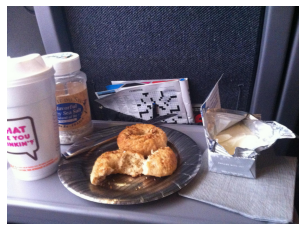

In [5]:
sample = matplotlib.image.imread(train_paths[0])
plt.imshow(sample)
plt.axis('off')
plt.show()

In [6]:
from torch.utils.data import Dataset

### 이미지 전처리 클래스 생성


class ColorizationDataset(Dataset):

    def __init__(self, paths, mode='train'):  # class가 생성될 때 실행되는 생성자
        self.mode = mode
        self.paths = paths

        if mode == 'train':  # train일 경우
            self.transforms = transforms.Compose(
                [  # pytorch.transforms.Compose를 사용하여 이미지 사이즈 조정과 데이터 증강을 체이닝 시키기.
                    transforms.Resize(
                        (256, 256),
                        Image.BICUBIC),  # Bicubic 보간법을 활용하여 이미지 사이즈 조정
                    transforms.RandomHorizontalFlip(),  # 수평 반전으로 데이터 증강
                ])
        elif mode == 'val':  # validation일 경우
            self.transforms = transforms.Resize((256, 256), Image.BICUBIC)
        else:
            raise Exception("train or val only!")  # 예외처리

    def __getitem__(self, index):  # 클래스의 인덱스에 접근할때 호출되는 메서드
        img = Image.open(self.paths[index]).convert(
            "RGB")  # 이미지 불러오기. 혹시 RGB가 아닌 이미지가 있을 수도 있으니 convert("RGB")
        img = np.array(
            self.transforms(img))  # 이미지 transform 진행 후 numpy array로 변환
        img = rgb2lab(img).astype("float32")  # RGB 채널을 Lab 채널로 변환
        img = transforms.ToTensor()(img)  # 텐서로 변환
        L = img[[0], ...] / 50. - 1.  # -1부터 1 사이로 정규화
        ab = img[[1, 2], ...] / 110.  # -1부터 1 사이로 정규화

        return {'L': L, 'ab': ab}

    def __len__(self):
        return len(self.paths)

In [7]:
### 데이터셋 전처리
dataset_train = ColorizationDataset(train_paths, mode='train')
dataset_val = ColorizationDataset(val_paths, mode='val')

### 데이터로더 만들기
dataloader_train = DataLoader(dataset_train,
                              batch_size=16,
                              num_workers=2,
                              pin_memory=True)
dataloader_val = DataLoader(dataset_val,
                            batch_size=16,
                            num_workers=2,
                            pin_memory=True)

# data = next(iter(train_dl))
# Ls, abs_ = data['L'], data['ab']
# print(Ls.shape, abs_.shape)
# print(len(train_dl), len(val_dl))

C:\Users\user\AppData\Local\Temp\ipykernel_14424\1133745880.py:17: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  Image.BICUBIC),  # Bicubic 보간법을 활용하여 이미지 사이즈 조정
C:\Users\user\AppData\Local\Temp\ipykernel_14424\1133745880.py:21: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  self.transforms = transforms.Resize((256, 256), Image.BICUBIC)


In [9]:
### pix2pix 생성자 선언
class pix2pix_Generator(nn.Module):

    def __init__(self):
        super(pix2pix_Generator, self).__init__()

        self.input_layer = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False), )

        self.encoder_1 = nn.Sequential(
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(128))

        self.encoder_2 = nn.Sequential(
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(256))

        self.encoder_3 = nn.Sequential(
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(512))

        self.encoder_4 = nn.Sequential(
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(512))

        self.encoder_5 = nn.Sequential(
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(512))

        self.encoder_6 = nn.Sequential(
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(512))

        self.middle = nn.Sequential(
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1,
                      bias=False), nn.ReLU(True),
            nn.ConvTranspose2d(512,
                               512,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False), nn.BatchNorm2d(512))

        self.decoder_6 = nn.Sequential(
            nn.ReLU(True),
            nn.ConvTranspose2d(1024,
                               512,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False), nn.BatchNorm2d(512),
            nn.Dropout(0.5))

        self.decoder_5 = nn.Sequential(
            nn.ReLU(True),
            nn.ConvTranspose2d(1024,
                               512,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False), nn.BatchNorm2d(512),
            nn.Dropout(0.5))

        self.decoder_4 = nn.Sequential(
            nn.ReLU(True),
            nn.ConvTranspose2d(1024,
                               512,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False), nn.BatchNorm2d(512),
            nn.Dropout(0.5))

        self.decoder_3 = nn.Sequential(
            nn.ReLU(True),
            nn.ConvTranspose2d(1024,
                               256,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False), nn.BatchNorm2d(256))

        self.decoder_2 = nn.Sequential(
            nn.ReLU(True),
            nn.ConvTranspose2d(512,
                               128,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False), nn.BatchNorm2d(128))

        self.decoder_1 = nn.Sequential(
            nn.ReLU(True),
            nn.ConvTranspose2d(256,
                               64,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False), nn.BatchNorm2d(64))

        self.output_layer = nn.Sequential(
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 2, kernel_size=4, stride=2, padding=1),
            nn.Tanh())

    def forward(self, x):
        input_layer = self.input_layer(x)

        encoder_1 = self.encoder_1(input_layer)
        encoder_2 = self.encoder_2(encoder_1)
        encoder_3 = self.encoder_3(encoder_2)
        encoder_4 = self.encoder_4(encoder_3)
        encoder_5 = self.encoder_5(encoder_4)
        encoder_6 = self.encoder_6(encoder_5)

        middle = self.middle(encoder_6)

        cat_6 = torch.cat((middle, encoder_6), dim=1)
        decoder_6 = self.decoder_6(cat_6)
        cat_5 = torch.cat((decoder_6, encoder_5), dim=1)
        decoder_5 = self.decoder_5(cat_5)
        cat_4 = torch.cat((decoder_5, encoder_4), dim=1)
        decoder_4 = self.decoder_4(cat_4)
        cat_3 = torch.cat((decoder_4, encoder_3), dim=1)
        decoder_3 = self.decoder_3(cat_3)
        cat_2 = torch.cat((decoder_3, encoder_2), dim=1)
        decoder_2 = self.decoder_2(cat_2)
        cat_1 = torch.cat((decoder_2, encoder_1), dim=1)
        decoder_1 = self.decoder_1(cat_1)

        x = self.output_layer(decoder_1)

        return x

In [10]:
pix2pix_Generator()

pix2pix_Generator(
  (input_layer): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (encoder_1): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace=True)
    (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (encoder_2): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace=True)
    (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (encoder_3): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace=True)
    (1): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (encoder_4): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace=True)
    (1): Conv2d(512, 512, kern

In [11]:
class pix2pix_Discriminator(nn.Module):

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128), nn.LeakyReLU(0.2, True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2,
                      padding=1, bias=False), nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(256, 512, kernel_size=4, stride=1,
                      padding=1, bias=False), nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1, bias=False))

    def forward(self, x):
        return self.model(x)

In [12]:
pix2pix_Discriminator()

pix2pix_Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  )
)

In [13]:
discriminator = pix2pix_Discriminator()
dummy_input = torch.randn(16, 3, 256, 256) # batch_size, channels, size, size
out = discriminator(dummy_input)
out.shape

torch.Size([16, 1, 30, 30])

In [14]:
def init_weights(m):
    if type(m) == nn.Conv2d:
        nn.init.normal_(m.weight.data, mean=0.0, std=0.02)
        print("nn.Conv2d initialized")
    elif type(m) == nn.ConvTranspose2d:
        nn.init.normal_(m.weight.data, mean=0.0, std=0.02)
        print("nn.ConvTransposed2d initialized")
    elif type(m) == nn.BatchNorm2d:
        nn.init.normal_(m.weight.data, mean=1., std=0.02)
        nn.init.constant_(m.bias.data, 0.)
        print("nn.BatchNorm2d initialized")


def initialize_model(model):
    model.apply(init_weights)
    return model

In [15]:
class GANLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(1.0))
        self.register_buffer('fake_label', torch.tensor(0.0))
        self.loss = nn.BCEWithLogitsLoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

In [16]:
# lab를 rgb로 만드는 함수를 만들어 봅시다!
def lab_to_rgb(L, ab):
    # L 채널에 / 50 해주었으니, * 50 해 줍시다!
    L = (L + 1.) * 50.
    # ab 채널에 / 110 해주었으니, * 110 해 줍시다!
    ab = ab * 110.
    # Lab 컬러 채널을 만들어 봅시다! permute가 사용된 이유는 [배치 사이즈, 채널, 256, 256]를 [배치 사이즈, 256, 256, 채널]로 만들기 위해서
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    # 이미지들을 저장할 리스트를 선언
    rgb_imgs = []
    # Lab에는 현재 이미지들이 들어가있는 상태. 한장씩 꺼내서!
    for img in Lab:
        # lab2rgb 라이브러리를 불러준다.
        img_rgb = lab2rgb(img)
        # rgb로 변환된 이미지들을 리스트에 저장합시다.
        rgb_imgs.append(img_rgb)
        # rgb 이미지들을 스택해서 보내줍시다!
    return np.stack(rgb_imgs, axis=0)

In [ ]:
import warnings

# generator를 초기화
model_generator = initialize_model(pix2pix_Generator())
# generator를 gpu로 보내기
model_generator.to(device)

# discriminator를 초기화
model_discriminator = initialize_model(pix2pix_Discriminator())
# discriminator를 gpu로 보내기
model_discriminator.to(device)

# 로스 함수 선언하기
criterion = GANLoss().to(device)
# L1 로스 함수 선언하기
L1 = nn.L1Loss()

# generator의 optimizer 선언하기
optimizer_generator = optim.Adam(model_generator.parameters(),
                                 lr=2e-4,
                                 betas=(0.5, 0.999))
# discriminator의 optimizer 선언하기
optimizer_discriminator = optim.Adam(model_discriminator.parameters(),
                                     lr=2e-4,
                                     betas=(0.5, 0.999))

# epoch 선언하기
epochs = 100

# 실제 훈련 시작! 에포크가 돕니다! -> 전체 트레이닝 셋이 한번씩 도는 것이 에포크!
for e in range(epochs):
    # tqdm 선언 -> for loop을 보여주기 위해 사용
    for index, data in enumerate(tqdm(dataloader_train)):

        # L 데이터를 gpu로 보냅시다!
        L = data['L'].to(device)
        # ab 데이터를 gpu로 보냅시다!
        ab = data['ab'].to(device)

        # generator에 L을 넣고, 나온 아웃풋 fake color를 얻어봅시다.
        fake_color = model_generator(L)
        # discriminator를 훈련시킵시다!
        model_discriminator.train()
        # discriminator를 훈련시키기 위해서 discriminator의 모든 파라미터에 대한 기울기를 저장하자! -> 백프롭을 하자!
        for parameter in model_discriminator.parameters():
            parameter.requires_grad = True
        # zero_grad -> pytorch에서는 interation이 끝나면 gradient를 항상 0으로 만들어 주어야 함. 이전 iteration의 기울기 값이 영향을 미칠 수 있기 때문.
        optimizer_discriminator.zero_grad()

        # L과 ab 채널을 합쳐서 가짜 이미지를 만들어줍시다!
        fake_image = torch.cat([L, fake_color], dim=1)
        # discriminator에 가짜 이미지를 넣어봅시다. 다만, 여기서 가짜 이미지는 건들이면 안되니, detach()를 사용하여 텐서를 복사합시다!
        fake_preds = model_discriminator(fake_image.detach())
        # discriminator의 로스를 재 봅시다!
        loss_discriminator_fake = criterion(fake_preds, False)
        # 그렇담 이번엔 진짜 이미지를 만들어 봅시다!
        real_image = torch.cat([L, ab], dim=1)
        # discriminator에 진짜 이미지를 넣어봅시다.
        real_preds = model_discriminator(real_image)
        # discriminator의 로스를 재 봅시다!
        loss_discriminator_real = criterion(real_preds, True)
        # discriminator의 전체 로스를 선언합시다! 두 로스를 더했으니 반으로 줄입시다!
        loss_discriminator_total = (loss_discriminator_fake +
                                    loss_discriminator_real) * 0.5
        # discriminator를 역전파시킵니다!
        loss_discriminator_total.backward()
        # 역전파 단계에서 수집된 변화도로 파라미터를 조정합시다!!!!!!
        optimizer_discriminator.step()

        # 자 이제 generator를 학습시켜봅시다!!!!
        model_generator.train()
        # generator를 학습해야 하니, discriminator를 잠시 freeze시킵니다!
        for parameter in model_discriminator.parameters():
            parameter.requires_grad = False
        # generator 학습에 앞서서, zero_grad()를 통해 기울기를 0으로 초기화해줍시다!
        optimizer_generator.zero_grad()
        # 가짜 이미지를 만들어봅시다!!!
        fake_image = torch.cat([L, fake_color], dim=1)
        # Generator가 생성한 가짜 이미지를 앞서 훈련된 discriminator에 넣어 봅시다!!!
        fake_preds = model_discriminator(fake_image)
        # Generator가 생성한 이미지를 discriminator가 어떻게 판단했는지를 확인하기 위해 loss를 계산합시다!
        loss_generator_GAN = criterion(fake_preds, True)
        # Generator에 생성한 컬러정보가 원본이랑 얼마나 다른지 L1 로스를 통해 알아봅시다! 100은 람다!
        loss_generator_L1 = L1(fake_color, ab) * 100.
        # Generator의 이미지에 대한 discriminator loss와, Generator가 생성한 ab 채널의 로스를 더해줍니다!
        loss_generator_total = loss_generator_GAN + loss_generator_L1
        # Generator를 역전파시킵니다!
        loss_generator_total.backward()
        # 역전파 단계에서 수집된 변화도로 generator를 변화시킵시다!!!
        optimizer_generator.step()

        # 200번재 인덱스마다
        if index % 200 == 0:
            # 에포크를 프린트
            print(f"\nEpoch {e+1}/{epochs}")
            # 몇번째 iteration인지 출력
            print(f"Iteration {index}/{len(dataloader_train)}")
            # 자잘한 오류 메세지를 없애기 위해
            with warnings.catch_warnings():
                # 자잘한 오류 메세지를 없애기 위해
                warnings.simplefilter("ignore")
                # generator가 훈련되면 안되니! eval mode로 변환!
                model_generator.eval()
                # generator 기울기 업데이트 막아버리자!
                with torch.no_grad():
                    # L채널을 gpu로 보낸다
                    L = data['L'].to(device)
                    # ab채널을 gpu로 보낸다
                    ab = data['ab'].to(device)
                    # generator에 넣어서 가짜 색을 입힌다.
                    fake_color = model_generator(L)
                # 다시 generator를 훈련 모드로 변환!
                model_generator.train()
                # 가짜 색 복사
                fake_color = fake_color.detach()
                # 진짜 색
                real_color = ab

                # 가짜 이미지를 생성하자
                fake_imgs = lab_to_rgb(L, fake_color)
                # 진짜 이미지를 생성하자
                real_imgs = lab_to_rgb(L, real_color)

                fig = plt.figure(figsize=(10, 8))
                ax = plt.subplot(3, 3, 1)
                ax.imshow(L[1][0].cpu(), cmap='gray')
                ax.axis("off")
                ax = plt.subplot(3, 3, 2)
                ax.imshow(fake_imgs[1])
                ax.axis("off")
                ax = plt.subplot(3, 3, 3)
                ax.imshow(real_imgs[1])
                ax.axis("off")
                plt.show()

nn.Conv2d initialized
nn.Conv2d initialized
nn.BatchNorm2d initialized
nn.Conv2d initialized
nn.BatchNorm2d initialized
nn.Conv2d initialized
nn.BatchNorm2d initialized
nn.Conv2d initialized
nn.BatchNorm2d initialized
nn.Conv2d initialized
nn.BatchNorm2d initialized
nn.Conv2d initialized
nn.BatchNorm2d initialized
nn.Conv2d initialized
nn.ConvTransposed2d initialized
nn.BatchNorm2d initialized
nn.ConvTransposed2d initialized
nn.BatchNorm2d initialized
nn.ConvTransposed2d initialized
nn.BatchNorm2d initialized
nn.ConvTransposed2d initialized
nn.BatchNorm2d initialized
nn.ConvTransposed2d initialized
nn.BatchNorm2d initialized
nn.ConvTransposed2d initialized
nn.BatchNorm2d initialized
nn.ConvTransposed2d initialized
nn.BatchNorm2d initialized
nn.ConvTransposed2d initialized
nn.Conv2d initialized
nn.Conv2d initialized
nn.BatchNorm2d initialized
nn.Conv2d initialized
nn.BatchNorm2d initialized
nn.Conv2d initialized
nn.BatchNorm2d initialized
nn.Conv2d initialized


  0%|          | 0/500 [00:00<?, ?it/s]